In [1]:
import mlflow
mlflow.set_tracking_uri('')
with mlflow.start_run():
    mlflow.log_param("param1", 15)
    mlflow.log_metric("metric1", 0.89)


In [2]:
!pip install numpy

In [3]:
import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [5]:
df.dropna(inplace=True)

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df=df[~(df['clean_comment'].str.strip()=='')]

In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [9]:
# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shahb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shahb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
# Define the preprocessing function
def preprocess_comment(comment):
    # Convert to lowercase
    comment = comment.lower()

    # Remove trailing and leading whitespaces
    comment = comment.strip()

    # Remove newline characters
    comment = re.sub(r'\n', ' ', comment)

    # Remove non-alphanumeric characters, except punctuation
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)

    # Remove stopwords but retain important ones for sentiment analysis
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

In [11]:
df['clean_comment']= df['clean_comment'].apply(preprocess_comment)

In [12]:
df.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [13]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
vectorize=CountVectorizer(max_features=5000)
X=vectorize.fit_transform(df['clean_comment']).toarray()
y=df['category']

In [15]:
mlflow.set_tracking_uri('http://ec2-3-27-214-151.ap-southeast-2.compute.amazonaws.com:5000/')
with mlflow.start_run():
    mlflow.log_param('params',5)
    mlflow.log_metric('matric', 0.89)
    mlflow.set_experiment("RF Baseline")

2024/11/18 12:13:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run victorious-stork-799 at: http://ec2-3-27-214-151.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/0/runs/133e95e44b854b7d94a582bb735d3087.
2024/11/18 12:13:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://ec2-3-27-214-151.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/0.


2024/11/18 12:14:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest_Baseline_TrainTestSplit at: http://ec2-3-27-214-151.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/301348904495029035/runs/d19a5a8b002b4f5cb5ac54d12a78f48f.
2024/11/18 12:14:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://ec2-3-27-214-151.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/301348904495029035.


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/confusion_matrix.png'

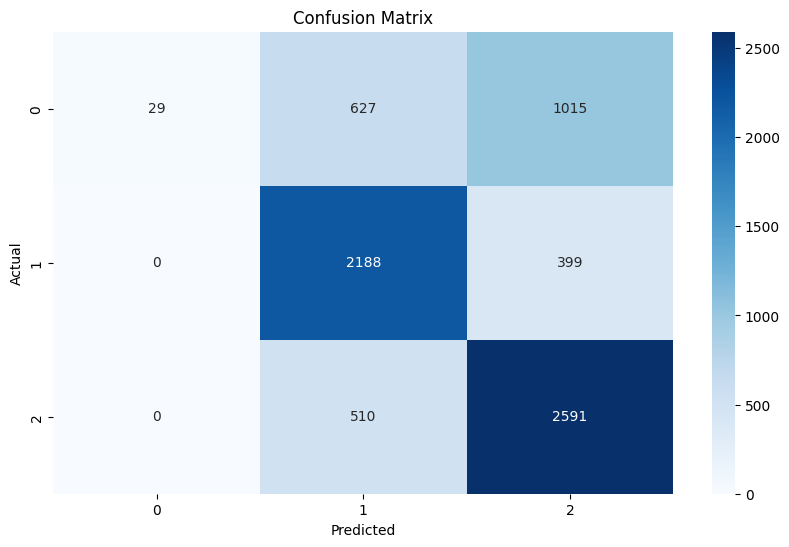

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

with mlflow.start_run() as run:
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")
    # Add a description
    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")
    
    mlflow.log_param('vectorizer_type','CountVectorizer')
    mlflow.log_param("vectorizer_max_features", vectorize.max_features)
    # Log Random Forest parameters
    n_estimators = 200
    max_depth = 15
    
    mlflow.log_param('n_estimators',n_estimators)
    mlflow.log_param('max_depth',max_depth)
    
    model=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,random_state=42)
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    
    accuracy=accuracy_score(y_test,y_pred)
    mlflow.log_metric('accuracy',accuracy)
   # Generate a classification report in dictionary format for detailed metrics
    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    # Iterate through the classification report dictionary
    for label, metrics in classification_rep.items():
        # Check if the value (metrics) is a dictionary (ignoring non-dict values like "accuracy")
        if isinstance(metrics, dict):
            # Iterate through each metric (e.g., precision, recall) and its value for the given label
            for metric, value in metrics.items():
                # Log the metric to MLflow with a unique name (e.g., "class1_precision")
                mlflow.log_metric(f"{label}_{metric}", value)

    conf_matrix=confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(10,6))
    sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    
    plt.savefig('confusion_matrix.png')
    mlflow.log_artifact("/content/confusion_matrix.png")
     # Log the Random Forest model
    mlflow.sklearn.log_model(model, "random_forest_model")

    # Optionally log the dataset itself (if it's small enough)
    df.to_csv("dataset.csv", index=False)
    mlflow.log_artifact("/content/dataset.csv")

print(f"Accuracy: {accuracy}")

In [17]:
df.to_csv('redit_preprocessing.csv',index=False)